In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from numpy.linalg import solve, norm


In [2]:
def expand_features(X, k, seed=42, sparse=True):
    """
    Blow up 30 original features → 30·k using a random projection.
    With sparse=True the projection is ultra-sparse (memory ≈ O(d)).
    """
    if k == 1:
        return X.copy()

    rng = np.random.default_rng(seed)
    n, d = X.shape
    D = d * k                     # new dimension

    if sparse:
        nnz = 3                   # non-zeros per new column
        P = np.zeros((d, D))
        for j in range(D):
            rows = rng.choice(d, nnz, replace=False)
            signs = rng.choice([-1, 1], nnz)
            P[rows, j] = signs
    else:
        P = rng.standard_normal((d, D))

    return X @ P                  # (n, D)


def make_train_test(k=1):
    """Return X_tr, X_te, y_tr, y_te with 30·k raw features (+bias)."""
    df = pd.read_csv("wdbc.data", header=None)
    df = df.drop(columns=0)
    df[1] = df[1].map({'M': 1, 'B': 0})

    X = df.drop(columns=1).values
    X = expand_features(X, k)              # explode dimension
    y = df[1].values.reshape(-1, 1)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.20, random_state=10, stratify=y
    )

    sc = StandardScaler()
    X_tr = sc.fit_transform(X_tr)
    X_te = sc.transform(X_te)

    # prepend bias column
    X_tr = np.c_[np.ones(X_tr.shape[0]), X_tr]
    X_te = np.c_[np.ones(X_te.shape[0]), X_te]
    return X_tr, X_te, y_tr, y_te



In [3]:
sigmoid  = lambda z: 1.0 / (1.0 + np.exp(-z))
logloss  = lambda p, y: -np.mean(y*np.log(p+1e-12) + (1-y)*np.log(1-p+1e-12))

def f(w, X, y):
    p = sigmoid(X @ w)
    return logloss(p, y)

def g(w, X, y):
    p = sigmoid(X @ w)
    return X.T @ (p - y) / len(y)

def H(w, X, _y=None):
    p = sigmoid(X @ w).ravel()
    S = p*(1.0-p)                      # length-n diag of Hessian blocks
    return (X.T * S) @ X / len(S)

def accuracy(w, X, y):
    return ((sigmoid(X @ w) >= 0.5).astype(int) == y).mean()


In [4]:
def newton(w0, X, y, maxit=50, tol=1e-6, lam=1e-4):
    w = w0.copy(); hist=[]
    I = np.eye(w.size)
    for _ in range(maxit):
        grad = g(w, X, y)
        if norm(grad) < tol: break
        Hreg = H(w, X) + lam*I          # ← ridge
        w -= solve(Hreg, grad)
        hist.append(f(w, X, y))
    return w, np.array(hist)

def lazy_newton(w0, X, y, k=5, maxit=50, tol=1e-6, lam=1e-4):
    w = w0.copy(); hist=[]; I = np.eye(w.size); Hk = H(w, X) + lam*I
    for it in range(maxit):
        grad = g(w, X, y)
        if norm(grad) < tol: break
        if it % k == 0:
            Hk = H(w, X) + lam*I        # ← ridge on refresh
        w -= solve(Hk, grad)
        hist.append(f(w, X, y))
    return w, np.array(hist)



=== starting k = 1  (raw dim = 30) ===


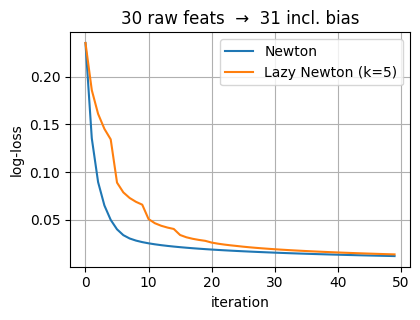

=== starting k = 10  (raw dim = 300) ===


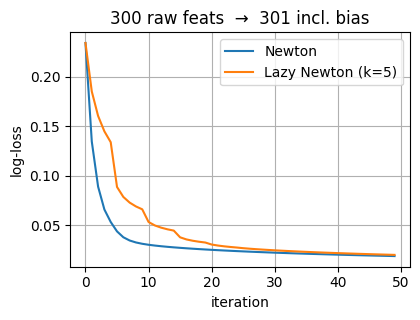

=== starting k = 50  (raw dim = 1500) ===


C:\Users\68404\AppData\Local\Temp\ipykernel_26348\1715849700.py:1: RuntimeWarning: overflow encountered in exp
  sigmoid  = lambda z: 1.0 / (1.0 + np.exp(-z))


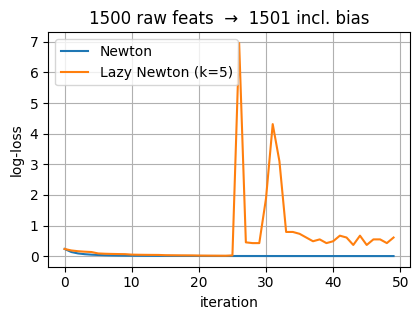

=== starting k = 200  (raw dim = 6000) ===


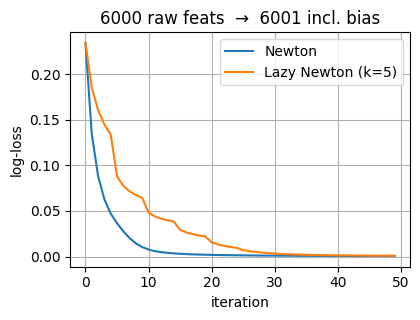


Raw features | Newton train/test | Lazy-Newton
         30 | 0.996 / 0.939 | 0.996 / 0.930
        300 | 0.993 / 0.947 | 0.991 / 0.947
       1500 | 1.000 / 0.947 | 0.978 / 0.965
       6000 | 1.000 / 0.956 | 1.000 / 0.956


In [5]:
# choose how much to scale feature space (1 → original 30 feats)
factors = [1, 10, 50, 200]          # feel free to modify

results = []

for k in factors:
    
    print(f"=== starting k = {k}  (raw dim = {30*k}) ===")
    
    X_tr, X_te, y_tr, y_te = make_train_test(k)
    d  = X_tr.shape[1]
    w0 = np.zeros((d, 1))

    wN,  lossN  = newton(w0,      X_tr, y_tr)
    wLN, lossLN = lazy_newton(w0, X_tr, y_tr, k=5)

    # store summary
    results.append(dict(
        feats = d-1,
        trainN = accuracy(wN,  X_tr, y_tr),  testN  = accuracy(wN,  X_te, y_te),
        trainL = accuracy(wLN, X_tr, y_tr),  testL  = accuracy(wLN, X_te, y_te)
    ))

    # plot
    plt.figure(figsize=(4.3,3.3))
    plt.plot(lossN,  label="Newton")
    plt.plot(lossLN, label="Lazy Newton (k=5)")
    plt.xlabel("iteration"); plt.ylabel("log-loss"); plt.grid(True)
    plt.title(f"{30*k} raw feats  →  {d} incl. bias")
    plt.legend(); plt.tight_layout()
    plt.show()

# summary table
print("\nRaw features | Newton train/test | Lazy-Newton")
for r in results:
    print(f"{r['feats']:>11} | {r['trainN']:.3f} / {r['testN']:.3f}"
          f" | {r['trainL']:.3f} / {r['testL']:.3f}")

